In [1]:
!nvidia-smi

Tue Jul 12 17:10:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.40       Driver Version: 516.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   51C    P3    32W /  N/A |    489MiB /  8192MiB |     32%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 資料讀取與前處理

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# 排序後資料集
df = pd.read_csv("MachineLearningCSV/MachineLearningCVE/week_2.csv")

# 第二資料集
df2 = pd.read_csv("MachineLearningCSV/Seg_NewDataSet/NewDataSet_25679_1.5m.csv")

df3 = pd.read_csv("MachineLearningCSV/bruteflows_with_label.csv")

# 資料集合併
df = pd.concat([df, df2], axis = 0, ignore_index = True)
df = pd.concat([df, df3], axis = 0, ignore_index = True)

# 丟掉部分資料
# df = df.drop(["Destination Port"], axis = 1)

# 取部分資料(取前二十特徵)
# df = df[["Flow Duration", "Bwd Packet Length Max", "Bwd Packet Length Min", "Bwd Packet Length Mean", "Bwd Packet Length Std", "Flow IAT Std",
#          "Flow IAT Max", "Fwd IAT Total", "Fwd IAT Std", "Fwd IAT Max", "Min Packet Length", "Max Packet Length", "Packet Length Mean", "Packet Length Std",
#          "Packet Length Variance", "Average Packet Size", "Avg Bwd Segment Size", "Idle Mean", "Idle Max", "Idle Min","Label"]]


df.columns = df.columns.str.strip()
print("original length of df:", len(df))
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print("after droping null values, the length of df:", len(df))

original length of df: 4331637
after droping null values, the length of df: 4328770


In [32]:
# df.dropna(inplace=True)
df.columns

Index(['Destination Port', 'Flow Duration', 'Flow Bytes/s', 'Flow Packets/s',
       'Fwd Packets/s', 'Bwd Packets/s', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Max Packet Length', 'Min Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'Fwd Header Length', 'Bwd Header Length', 'min_seg_size_forward',
       'act_data_pkt_fwd', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min',
       'Flow IAT Std', 'Fwd IAT Total', 'Fwd IAT Max', 'Fwd IAT Min',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Bwd IAT Total', 'Bwd IAT Max',
       'Bwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Std', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG F

In [2]:
# 2-calss or Multiclass
df_experiment = df.copy()
df_experiment.Label.replace("Web.*", "Web Attack", regex=True, inplace=True)
df_experiment.Label.replace(r'.*Patator$', "Brute Force", regex=True,inplace=True)
df_experiment.Label.replace(["DoS GoldenEye", "DoS Hulk", "DoS Slowhttptest", "DoS slowloris"], "DoS", inplace=True)

# for new dataset, class_attack = ['Syn', 'UDP-lag']
df_experiment.Label.replace(["DrDoS.*", "WebDDoS"], "DDoS", regex=True, inplace=True)


class_attack = ['PortScan', 'Web Attack', 'Brute Force', 'DDoS', 'Bot','Infiltration', 'DoS', 'Heartbleed', 'Syn', 'UDP-lag']
df_experiment.Label.replace(class_attack, value='attack', inplace=True)
df_experiment.Label.value_counts()

BENIGN    2273574
attack    2055196
Name: Label, dtype: int64

In [3]:
# data split and preprocess
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn import preprocessing

y = df_experiment.Label
X = df_experiment.drop(columns='Label')
labels = y.unique()

std_scaler = preprocessing.StandardScaler().fit(X)
X = std_scaler.transform(X)

classes = y.nunique()
print(X.shape)
print("number of labels:", classes)
print("instances per label\n", y.value_counts())
print("labels:", labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
# print(len(df_experiment))
# print(df_experiment.Label.nunique())
# print(df_experiment.Label.value_counts())
print("after spliting the data:\n")
print("training data length:", len(X_train))
print("test data length:", len(X_test))
# print(y_train.nunique())
# print(y_train.value_counts())

(4328770, 77)
number of labels: 2
instances per label
 BENIGN    2273574
attack    2055196
Name: Label, dtype: int64
labels: ['BENIGN' 'attack']
after spliting the data:

training data length: 3246577
test data length: 1082193


In [4]:
# 資料前處理
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
mm_scaler = MinMaxScaler()
le = LabelEncoder()

X_train = mm_scaler.fit_transform(X_train)
X_test = mm_scaler.transform(X_test)
print("instances per label in training set\n", y_train.value_counts())
y_train = le.fit_transform(y_train)
print("instances per label in test set\n", y_test.value_counts())
y_test = le.transform(y_test)

print(X_train.shape)
print(X_test.shape)
labels_dict = dict(zip(le.classes_, range(len(le.classes_))))
print(labels_dict)

instances per label in training set
 BENIGN    1705180
attack    1541397
Name: Label, dtype: int64
instances per label in test set
 BENIGN    568394
attack    513799
Name: Label, dtype: int64
(3246577, 77)
(1082193, 77)
{'BENIGN': 0, 'attack': 1}


In [ ]:
# 資料選擇 / 目前沒做
### transform ndarray into dataframe type for later operation.
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

from sklearn.feature_selection import f_classif
### Compute the ANOVA F-value 
f_value = f_classif(X_train, y_train)

# f_value = pd.Series(f_value)
# f_value.index = X_train.columns
# f_value.sort_values(ascending=False)

# ### plot the ordered f_value per feature
# f_value.sort_values(ascending=False).plot.bar(figsize=(20, 8))

### Now we select the top 10 important features based on the result above.
from sklearn.feature_selection import SelectKBest
sel_top_cols = SelectKBest(f_classif, k=10)
sel_top_cols.fit(X_train, y_train)
X_train.columns[sel_top_cols.get_support()]

### transform ndarray back:
X_train = X_train.values
X_test = X_test.values

In [61]:
#儲存資料前處理資料
import joblib as jb

# jb.dump([std_scaler, mm_scaler, le], 'model/std_mm_le_all_feature.save')
jb.dump([std_scaler, mm_scaler, le], 'exe/new_model/25679_std_mm_le_20_feature.save')

['exe/new_model/25679_std_mm_le_20_feature.save']

In [22]:
df_experiment.Label.value_counts()

BENIGN    2272895
attack    2054981
Name: Label, dtype: int64

# Random Forest

In [6]:
###### Random Forest
from sklearn.ensemble import RandomForestClassifier, IsolationForest, ExtraTreesClassifier
from sklearn.linear_model import BayesianRidge, ARDRegression
from sklearn.cluster import KMeans, MiniBatchKMeans
import joblib as jb

rng = np.random.RandomState(42)

# model = jb.load("new_model/pkl/0.5_randomForest_test.pkl")
# model = RandomForestClassifier(n_estimators = 64, random_state=rng)
# model.fit(X_train, y_train)
# model = IsolationForest(n_estimators=64, random_state=rng)
model = ExtraTreesClassifier(n_estimators=32)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(y_pred)
print(y_pred.shape)

print("percentage of Anomaly:", (list(y_pred).count(1)/y_pred.shape[0])*100)
print("percentage of Legit:",(list(y_pred).count(0)/y_pred.shape[0])*100)

[0 1 0 ... 0 0 1]
(1082193,)
percentage of Anomaly: 47.471384494263035
percentage of Legit: 52.528615505736965


In [13]:
###### Random Forest
from sklearn.ensemble import RandomForestClassifier, IsolationForest, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostRegressor, HistGradientBoostingRegressor, HistGradientBoostingClassifier, VotingClassifier, VotingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import BayesianRidge, ARDRegression, LinearRegression
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.svm import SVC
import joblib as jb

rng = np.random.RandomState(42)

# model = jb.load("new_model/pkl/0.5_randomForest_test.pkl")
# model = RandomForestClassifier(n_estimators = 64, random_state=rng)
# model.fit(X_train, y_train)
# model = IsolationForest(n_estimators=64, random_state=rng)
model2 = SVC(kernel='rbf', probability=True)
model2.fit(X_train, y_train)

y_pred = model2.predict(X_test)
print(y_pred)
print(y_pred.shape)

print("percentage of Anomaly:", (list(y_pred).count(1)/y_pred.shape[0])*100)
print("percentage of Legit:",(list(y_pred).count(0)/y_pred.shape[0])*100)

In [16]:
y_pred.sum()/1082193

0.4750264468535291

In [25]:
y_pred = np.where(y_pred == 1, 0, 1)

In [12]:
y.unique()

array(['BENIGN', 'attack'], dtype=object)

In [7]:
# 混淆矩陣
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cf_matrix.ravel()
cf_matrix

array([[567874,    520],
       [   587, 513212]], dtype=int64)

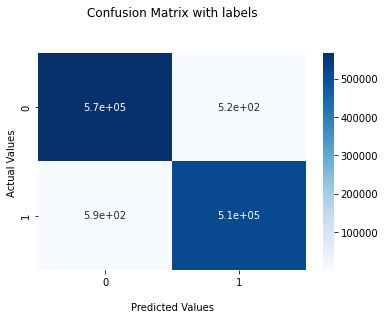

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt 
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
# ax.xaxis.set_ticklabels(['BENIGN','Attack'])
# ax.yaxis.set_ticklabels(['BENIGN','Attack'])

## Display the visualization of the Confusion Matrix.
plt.show()

# plt.savefig('img/new_confusion_matrix_32.png')
# plt.savefig('new_img/confusion_matrix_20_feature_32_1.5m.png', bbox_inches = 'tight')

In [93]:
mlm = multilabel_confusion_matrix(y_train_labels, y_train_pred_labels, labels=le.classes_)

In [98]:
mlm[1]

array([[505806,  62588],
       [468997,  44802]], dtype=int64)

In [10]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
def multilabel_matrix(y_true, y_pred, labels=None):
    mlm = multilabel_confusion_matrix(y_true, y_pred, labels=labels)
    df_performance = pd.DataFrame(index=labels, columns=['accuracy', 'precision',
                                                         'recall', 'f1_score', 'support'])
    for i, label in enumerate(labels):
        tn, fn, fp, tp = mlm[i].ravel()
        accuracy = (tn + tp) / (tn + fp + fn + tp)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        support = tp + fn

        f1_score = 2*precision * recall / (precision + recall)
        df_performance.loc[label] = [round(accuracy, 4), round(precision,4), \
                                     round(recall, 4), round(f1_score,4), support]
    return df_performance

In [8]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
y_train_pred_labels = le.inverse_transform(y_pred)
y_train_labels = le.inverse_transform(y_test)
print(classification_report(y_train_labels, y_train_pred_labels))

# performance = multilabel_matrix(y_train_pred_labels, y_train_labels, labels=le.classes_)
# performance

              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00    568394
      attack       1.00      1.00      1.00    513799

    accuracy                           1.00   1082193
   macro avg       1.00      1.00      1.00   1082193
weighted avg       1.00      1.00      1.00   1082193



In [11]:
performance = multilabel_matrix(y_train_pred_labels, y_train_labels, labels=le.classes_)
performance

,accuracy,precision,recall,f1_score,support
BENIGN,0.999,0.999,0.9991,0.999,568394
attack,0.999,0.999,0.9989,0.9989,513799


# 儲存模型檔

In [68]:
# jb.dump(model, 'model/pkl/new_20_feature_randomForest_32.pkl')
jb.dump(model, 'exe/new_model/pkl/25679_randomForest_20_feature_32.pkl')

['exe/new_model/pkl/25679_randomForest_20_feature_32.pkl']

# 畫圖小工具

In [ ]:
from functools import reduce

def _get_model_name(model):
    """
            Returns a string with the name of a sklearn model
                model: Sklearn stimator class
    """
    if isinstance(model, Pipeline):
        estimator = model.steps[-1][1]
        name = "Pipeline_" + str(estimator)[:str(estimator).find("(")]
    else: 
        name = str(model)[:str(model).find("(")]
    return name
    
    
def plot_cv_score(X, y, models_list, cv = 5, scoring_list = None, refit = True, return_scores = True):
    """ 
            X: numpy_array/pandas dataframe n_rows, m_features
            y: numpy_array/pandas dataframe n_rows
            Plots min, max and avg kfold crosval_score for a list of models
        
    """
    
        
        
    names, mean_score = list(), list()
    ldf = list()
    mnames = list()
    
    for i, model in enumerate(models_list):
        name = _get_model_name(model)
    
        if refit:
            model.fit(X, y)
                
        for metric in score_list:
            
            score = cross_val_score(model, X, y, cv = cv, scoring = metric, n_jobs= -1)
            mean_score.append(np.mean(score))
    
    
        tmp = pd.DataFrame({name: mean_score}, index = score_list)
        
            
            
        ldf.append(tmp)
        
        
        mean_score = list()
        
    frame_scores = reduce(lambda x,y: pd.merge(x,y, left_index = True, right_index = True), ldf).T
    print(frame_scores)
    
    
    fig, ax  = plt.subplots(1,1, figsize = (10,5))

    frame_scores.plot.bar(ax = ax, cmap = 'RdYlBu', edgecolor = "black")
    ax.legend(loc = 'best')
    ax.set_ylabel("Score")
    ax.set_title("Cross validation model benchmark")

    if return_scores:    
        return frame_scores

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

X, y = load_breast_cancer(return_X_y= True)

models_list =[LogisticRegression(random_state= 42),
            #   SVC(probability= True),
              RandomForestClassifier(random_state = 42),
              GaussianNB()]

score_list = ["roc_auc", "accuracy", "f1", "precision", "recall"]

t = plot_cv_score(X = X, y = y, models_list = models_list, cv = 5, scoring_list = score_list, refit = True)

In [ ]:
import pandas as pd  
  
# assign data of lists.  
data = {'Accuracy': [0.9764, 0.9818, 0.9991, 0.9985, 0.9884], 
        'Precision':[0.9761, 0.9816, 0.9991, 0.9985, 0.9882],
        'Recall':[0.9767, 0.9819, 0.9992, 0.9985, 0.9885],
        'F1-Score':[0.9763, 0.9817, 0.9991, 0.9985, 0.9883],}  
  
# Creates pandas DataFrame.  
df = pd.DataFrame(data, index =['GradientBoostingClassifier', 'GradientBoostingRegressor', 'HistGradientBoostingClassifier', 'HistGradientBoostingRegressor', 'AdaBoostClassifier'])  
  
# print the data  
print(df)  

In [ ]:
fig, ax  = plt.subplots(1,1, figsize = (12,5))

df.plot.bar(ax = ax, cmap = 'GnBu', edgecolor = "black")
plt.ylim(0.95,1)
ax.legend(loc = 'best')
ax.set_ylabel("Score", fontproperties = "Times New Roman", fontweight = 'bold', fontsize = 14)
ax.set_xlabel("Model", fontproperties = "Times New Roman", fontweight = 'bold', fontsize = 14)
plt.yticks(fontproperties = "Times New Roman", size = 12, weight = "bold")
plt.xticks(fontproperties = "Times New Roman", size = 12, weight = "bold", rotation = 355)
ax.set_title("Evaluation metrics among different models", fontproperties = "Times New Roman", fontweight = 'bold', fontsize = 15)